# GNNs

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GeneralConv, GENConv
from torch_geometric.nn.models import MLP
from torch_geometric.data import Data
from torch_geometric.nn import radius_graph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from datagen import generate_dataset, generate_dataset_nbodies, generate_dataset_1gal, generate_scene_1gal
from tqdm import tqdm



def fully_connected(input_dim, hidden_dim, output_dim, num_layers):
    layers = []
    # Add hidden layers
    for _ in range(num_layers):
        layers.append(torch.nn.Linear(input_dim, hidden_dim))
        layers.append(torch.nn.ReLU())
        input_dim = hidden_dim
    # Add output layer
    layers.append(torch.nn.Linear(hidden_dim, output_dim))
    return torch.nn.Sequential(*layers)

def create_edge_attributes_based_on_mass_and_dist(data):
    row, col = data.edge_index  # Get indices of connected nodes
    # Get masses for each node in the connection
    pos_row = data.x[row][:, :3]
    pos_col = data.x[col][:, :3]
    distance = torch.norm(pos_row - pos_col, dim=1)  # Calculate distance between nodes
    mass_row = data.x[row][:, -1]
    mass_col = data.x[col][:, -1]
    mass_prod = mass_row * mass_col  # Multiply masses
    data.edge_attr = torch.stack([mass_prod, distance], dim=1)  # Concatenate edge attributes
    
    return data

class ParticleGNN(torch.nn.Module):
    def __init__(self, input_dim=9, edge_dim=2,  node_enc_hidden = [128, 256], edge_enc_hidden = [128, 256], dec_hidden = [256, 128], gnn_dim=256, message_passing_steps=5, agg='mean', output_dim=3):
        super(ParticleGNN, self).__init__()
        # Encoder for initial node features
        self.node_encoder = MLP([input_dim] + node_enc_hidden + [gnn_dim])
        self.edge_encoder = MLP([edge_dim] + edge_enc_hidden + [gnn_dim])
        # GeneralConv layers for message passing
        self.gnns = []
        for i in range(message_passing_steps):
            gnn = GENConv(in_channels=gnn_dim, out_channels=gnn_dim, aggr=agg, edge_dim=gnn_dim)
            setattr(self, f'gnn_{i}', gnn)
            self.gnns.append(gnn)
        
        # Decoder to transform final node features to output
        self.decoder = MLP([gnn_dim] + dec_hidden + [output_dim])

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr  # Use edge_attr instead of edge_weight
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)
        
        for gnn in self.gnns:
            x = F.relu(gnn(x, edge_index, edge_attr=edge_attr))  # Pass edge_attr to GeneralConv
        
        x = self.decoder(x)
        return x



# Function to convert particles to a torch_geometric Data object
def transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius):

    edge_index = radius_graph(positions, r=radius)

    # Create data object
    graph_data = Data(x=features, edge_index=edge_index)
    
    # Add edge weights based on mass
    graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
    return graph_data





## Loss function:

In [2]:
def euclidean_distance(a, b):
    return torch.sqrt(torch.sum((a - b)**2, dim=-1) + 1e-12)

def mean_distance(a, b):
    return torch.mean(euclidean_distance(a, b))

## Graph dataset generator

In [3]:
import torch
def generate_graph_dataset(data, radius):
    graphs = []
    for i in tqdm(range(len(data))):
        masses = torch.tensor(data[i]['masses']).unsqueeze(-1)
        positions = torch.tensor(data[i]['pos'])
        velocities = torch.tensor(data[i]['vel'])
        Gs = torch.ones_like(masses) 
        softening = torch.ones_like(masses) * 0.1
        features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
        graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, radius)
        graph_data.y = torch.tensor(data[i]['acc'])
        graphs.append(graph_data)
    return graphs

## Model declaration

In [4]:
# Initialize model and optimizer
import os
model = ParticleGNN()
# load model weights
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = model.to(device)
#model.load_state_dict(torch.load('./models/'+sorted(os.listdir('models'), key=lambda x: int(x.split('.')[0].split('_')[-1]))[-1], map_location=torch.device(device)))


In [5]:
torch.cuda.empty_cache()

## Train loop

In [ ]:
import gc
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

ROUNDS = 50
EPOCHS = 4
SCENES = 50 
WINDOW_SIZE = 0
N_BODIES = 100
BATCH_SIZE = 64
RADIUS = 1.0
CHECKPOINT = 5

try:
    last_model_id = sorted([int(x.split('.')[0].split('_')[-1]) for x in os.listdir('models')])[-1]
    model.load_state_dict(torch.load(f'./models/particle_gnn_{last_model_id}.pth', map_location=torch.device(device)))
    print(f'Loaded model from ./models/particle_gnn_{last_model_id}.pth')
    last_model_id += 1
except:
    print('No model found, training from scratch')
    last_model_id = 0

# Training loop
model.train()
for r in range(ROUNDS):
    print(f'--- Round {r} ---')
    data = generate_dataset_1gal(n_scenes=SCENES, window_size=WINDOW_SIZE)
    print('Converting to graphs...')
    graphs = generate_graph_dataset(data, RADIUS)
    dataloader = DataLoader(graphs, batch_size=BATCH_SIZE)
    print('Training...')
    for epoch in range(EPOCHS):
        epoch_losses = []
        print(f'Epoch {epoch+1}')
        for data in tqdm(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            loss = mean_distance(out, data.y)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
            del data
            torch.cuda.empty_cache()
            #torch.mps.empty_cache()
        print(f'Epoch {epoch+1}, Loss: {torch.tensor(epoch_losses).mean()}')
    del graphs, dataloader
    torch.cuda.empty_cache()
    #torch.mps.empty_cache()
    gc.collect()
    if (r+1) % CHECKPOINT == 0:
        print('Saving model...')
        torch.save(model.state_dict(), f'./models/particle_gnn_{last_model_id}.pth')
        last_model_id += 1
    







## Rollout + plot

Simulation time: 19.39s
Prediction time: 10.52s


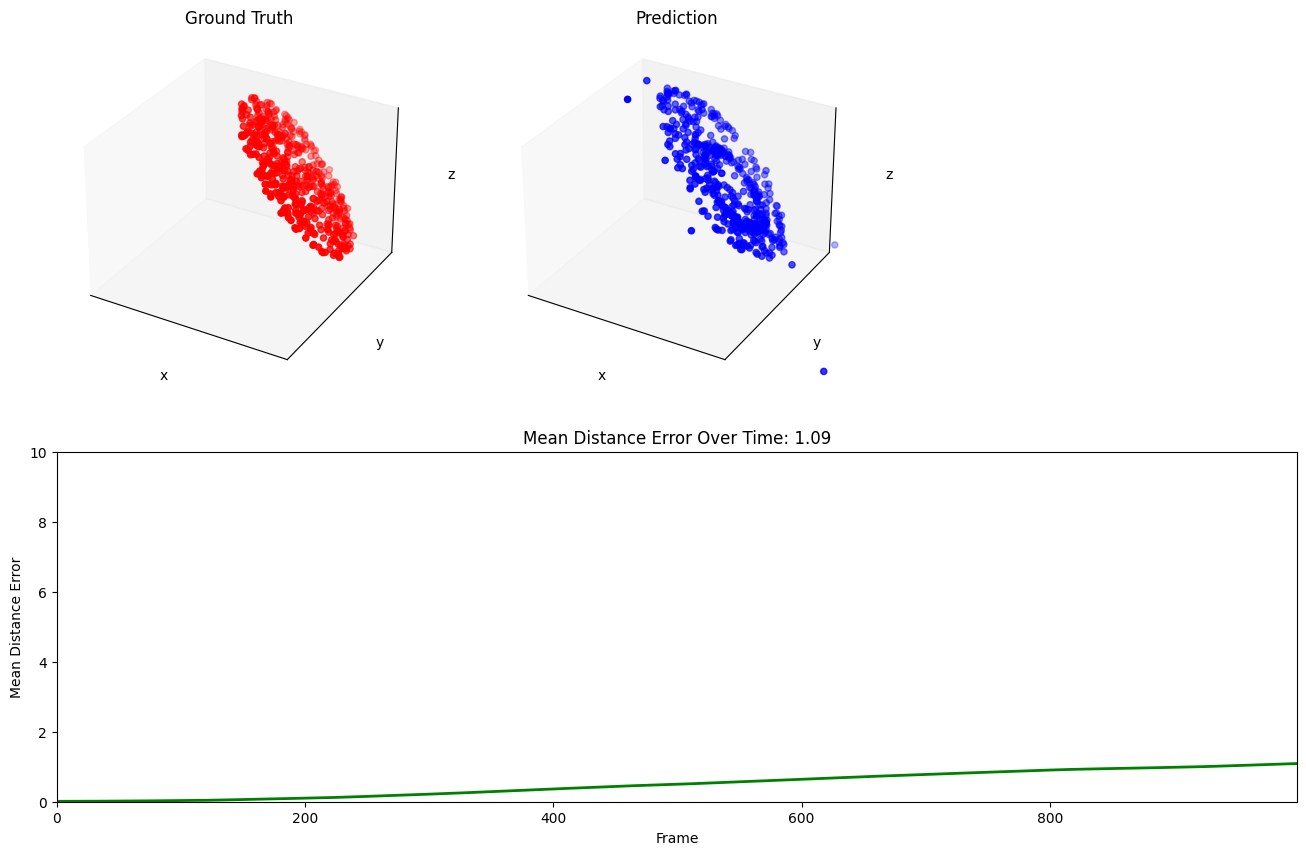

In [13]:
from datagen import generate_n_body_scene
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# animate the scene in 3d comparing the predicted scene with the actual scene
def get_new_pos_vel(acc, pos, vel, dt=0.01):
    new_vel = vel + acc * dt
    new_pos = pos + new_vel * dt
    return new_pos, new_vel

def sim_accelerations(positions, masses, G=1.0, softening=0.1):
    x = positions[:, 0:1]
    y = positions[:, 1:2]
    z = positions[:, 2:3]
    
    dx = x.T - x
    dy = y.T - y
    dz = z.T - z

    inv_r3 = (dx**2 + dy**2 + dz**2 + softening**2)
    inv_r3[inv_r3 > 0] = inv_r3[inv_r3 > 0]**(-1.5)
    
    ax = G * (dx * inv_r3) @ masses
    ay = G * (dy * inv_r3) @ masses
    az = G * (dz * inv_r3) @ masses

    return np.hstack((ax, ay, az))

def generate_rollout(model, scene, n_steps=1000, dt=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            out = model(graph_data)
            acc = out.cpu().numpy()
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)

def generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.5):

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    masses = torch.tensor(scene['masses']).unsqueeze(-1)
    positions = torch.tensor(scene['frames'][0]['pos'])
    velocities = torch.tensor(scene['frames'][0]['vel'])
    Gs = torch.ones_like(masses)
    softening = torch.ones_like(masses) * 0.1
    features = torch.cat([positions, velocities, Gs, softening, masses], dim=-1)
    graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(features, positions, RADIUS)
    graph_data = graph_data.to(device)
    pos_pred = []
    acc_pred = []
    model.eval()
    with torch.no_grad():
        for i in range(n_steps):
            if np.random.rand() < model_percentage:
                out = model(graph_data)
                acc = out.cpu().numpy()
            else:
                acc = sim_accelerations(positions.numpy(), masses.numpy())
            acc_pred.append(acc)
            new_pos, new_vel = get_new_pos_vel(acc, positions, velocities, dt=dt)
            new_feats = torch.cat([new_pos, new_vel, Gs, softening, masses], dim=-1)
            graph_data = transform_particles_to_graph_with_radius_and_mass_edge_weights(new_feats, new_pos, RADIUS)
            graph_data = create_edge_attributes_based_on_mass_and_dist(graph_data)
            positions = new_pos
            velocities = new_vel
            pos_pred.append(new_pos)
            graph_data = graph_data.to(device)
    return np.array(pos_pred), np.array(acc_pred)


import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

def animate_scene(scene, pos_pred):
    # Create a 2D animation with a line plot below
    fig = plt.figure(figsize=(16, 10))

    # 3D scatter plot for Ground Truth
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.set_xlim(-2, 2)
    ax1.set_ylim(-2, 2)
    ax1.set_zlim(-2, 2)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('z')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_zticks([])
    ax1.set_title('Ground Truth')

    # 3D scatter plot for Prediction
    ax2 = fig.add_subplot(232, projection='3d')
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    ax2.set_zlim(-2, 2)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_title('Prediction')

    # Line plot for mean distance error over time
    ax3 = fig.add_subplot(212)
    ax3.set_xlim(0, len(pos_pred) - 1)
    ax3.set_ylim(0, 10)
    ax3.set_xlabel('Frame')
    ax3.set_ylabel('Mean Distance Error')
    ax3.set_title('Mean Distance Error Over Time: 0.0')
    line, = ax3.plot([], [], color='g', lw=2)

    # Prepare the data
    n_bodies = len(scene['masses'])
    gt_pos = np.array([frame['pos'] for frame in scene['frames']])
    scat1 = ax1.scatter(gt_pos[0, :, 0], gt_pos[0, :, 1], gt_pos[0, :, 2], c='r')
    scat2 = ax2.scatter(pos_pred[0, :, 0], pos_pred[0, :, 1], pos_pred[0, :, 2], c='b')

    # Calculate mean distances for each frame
    mean_distance_per_step = [
        mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item()
        for i in range(len(pos_pred))
    ]
    ax3.set_title(f'Mean Distance Error Over Time: {mean_distance_per_step[0]:.2f}')

    # Update function for animation
    def update(frame):
        # Update 3D scatter plots
        scat1._offsets3d = (gt_pos[frame, :, 0], gt_pos[frame, :, 1], gt_pos[frame, :, 2])
        scat2._offsets3d = (pos_pred[frame, :, 0], pos_pred[frame, :, 1], pos_pred[frame, :, 2])

        # Update line plot with error values up to current frame
        line.set_data(np.arange(frame + 1), mean_distance_per_step[:frame + 1])
        ax3.set_title(f'Mean Distance Error Over Time: {mean_distance_per_step[frame]:.2f}')
        
        return scat1, scat2, line

    # Create animation
    anim = FuncAnimation(fig, update, frames=len(pos_pred), blit=True, interval=10)

    return anim, mean_distance_per_step



import time

start_sim = time.time()
scene = generate_scene_1gal(n=500, M=1.5, R=2.0)
end_sim = time.time()
print(f'Simulation time: {end_sim - start_sim:.2f}s')
start_pred = time.time()
pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=0.33)
end_pred = time.time()
print(f'Prediction time: {end_pred - start_pred:.2f}s')
ani, mean_dist = animate_scene(scene, pos_pred)
HTML(ani.to_html5_video())

## Metrics calculation

In [30]:

particles_nums = range(100, 1001, 100)
sim_percentage = range(10, 101, 10)

data = dict()
data['percentages'] = []
data['particles'] = []
data['sim_times'] = []
data['pred_times'] = []
data['mean_distances'] = []
scenes = []
times_sim = []
for n in particles_nums:
    time_sim = time.time()
    scene = generate_scene_1gal(n=n, M=1.5, R=2.0)
    time_sim_end = time.time()
    scenes.append(scene)
    times_sim.append(time_sim_end - time_sim)

print('Simulations done')

for p in sim_percentage:
    for n in particles_nums:
        scene = scenes[particles_nums.index(n)]
        data['percentages'].append(p)
        data['particles'].append(n)
        data['sim_times'].append(times_sim[particles_nums.index(n)])
        start_pred = time.time()
        pos_pred, acc_pred = generate_rollout_mixed(model, scene, n_steps=1000, dt=0.01, model_percentage=p/100)
        end_pred = time.time()
        data['pred_times'].append(end_pred - start_pred)
        gt_pos = np.array([frame['pos'] for frame in scene['frames']])
        mean_distance_per_step = [
            mean_distance(torch.tensor(pos_pred[i]), torch.tensor(gt_pos[i])).item()
            for i in range(len(pos_pred))
        ]
        data['mean_distances'].append(torch.tensor(mean_distance_per_step).mean().item())
    print(f'{p}% done')



Simulations done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


In [33]:
import pandas as pd
df = pd.DataFrame(data)
df.to_csv('mixed_model_results.csv', index=False)

In [17]:
df

,percentages,particles,sim_times,pred_times,mean_distances
0,10,100,1.927601,2.688898,0.624198
1,10,200,3.238049,4.011621,0.471071
2,10,300,5.884166,7.432655,0.329073
3,10,400,14.452601,9.698836,0.422237
4,10,500,20.039934,10.904217,0.306366
...,...,...,...,...,...
95,100,600,26.284924,8.673763,8.393072
96,100,700,33.194109,9.472023,9.607722
97,100,800,42.713005,10.582533,22.503689
98,100,900,52.313756,10.056975,48.250275


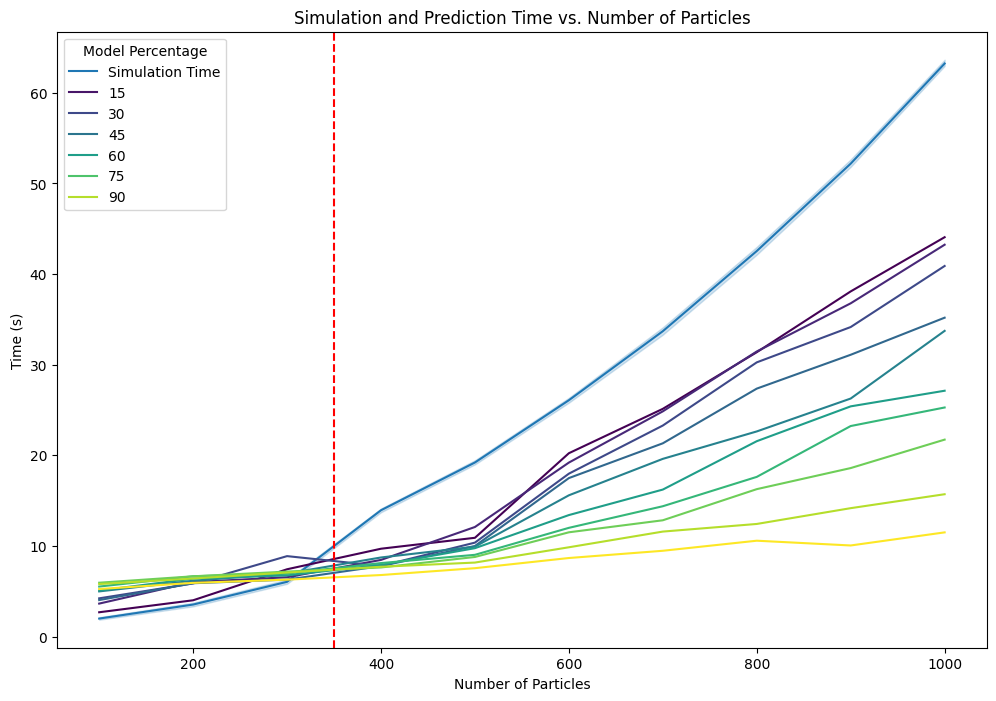

In [31]:
# plot the results
import seaborn as sns
import matplotlib.pyplot as plt

# for every number of particles, plot the mean prediction time for different percentages of simulation as well as ground truth
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='particles', y='sim_times', label='Simulation Time')
sns.lineplot(data=df, x='particles', y='pred_times', hue='percentages', palette='viridis')
plt.axvline(x=350, color='r', linestyle='--')

plt.title('Simulation and Prediction Time vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Time (s)')
plt.legend(title='Model Percentage')
plt.show()

C:\Users\vramo\AppData\Local\Temp\ipykernel_13148\392812410.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='particles', y='mean_distances', hue='percentages', palette='viridis', ci=None)


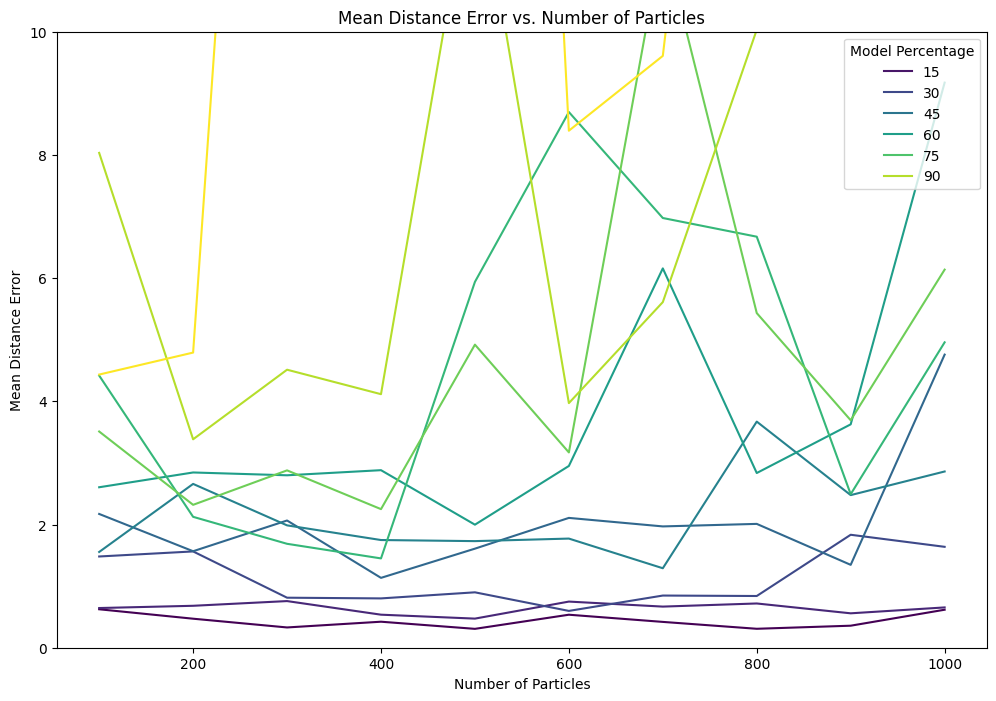

In [32]:
# for every number of particles, plot the mean distance error for different percentages of simulation as well as ground truth
plt.figure(figsize=(12, 8))
sns.lineplot(data=df, x='particles', y='mean_distances', hue='percentages', palette='viridis', ci=None)

plt.title('Mean Distance Error vs. Number of Particles')
plt.xlabel('Number of Particles')
plt.ylabel('Mean Distance Error')
plt.legend(title='Model Percentage')
plt.ylim(0, 10)
plt.show()